# Hold me tight! Influence of discriminative features on deep network boundaries

**Authors**: Guillermo Ortiz-Jimenez, Apostolos Modas, Seyed-Mohsen Moosavi-Dezfooli and Pascal Frossard

## Requirements

For executing the code, please make sure that you meet the following requirements:

* python (Successfully tested on v3.8.3)
* [PyTorch](https://pytorch.org/get-started/previous-versions/) (Successfully tested on v1.5.0 with CUDA v10.0.130)
* [Torchvision](https://pytorch.org/get-started/previous-versions/) (Successfully tested on v0.6.0 with CUDA v10.0.130)
* [NumPy](https://numpy.org/) (Successfully tested on v1.18.1)
* [torch-dct](https://github.com/zh217/torch-dct) (Successfully tested on v0.1.5)
* [Matplotlib](https://matplotlib.org/) (Successfully tested on v3.1.3)

In our experiments, every package was installed through a Conda environment. Assuming CUDA v10.0.130 and Conda v4.8.1 (installed through [Miniconda3](https://docs.conda.io/en/latest/miniconda.html) on CentOS Linux 7), these are the corresponding commands:

&nbsp;&nbsp;&nbsp; ```conda create -n hold_me_tight python==3.8.3```  
&nbsp;&nbsp;&nbsp; ```conda activate hold_me_tight```  
&nbsp;&nbsp;&nbsp; ```conda install numpy==1.18.1```  
&nbsp;&nbsp;&nbsp; ```conda install pytorch=1.5.0 torchvision=0.6.0 cudatoolkit=10.1 -c pytorch```  
&nbsp;&nbsp;&nbsp; ```pip install torch-dct==0.1.5```  
&nbsp;&nbsp;&nbsp; ```conda install matplotlib==3.1.3```

## Table of contents

- [Margin distribution on diagonal of DCT](#margin)
    - [Training LeNet on MNIST](#mnist)
    - [Evaluating LeNet on MNIST](#margin)
    - [LeNet on flipped MNIST](#flipped)
- [Frequency manipulated image examples](#images)
    - [Flipped data](#flipped_im)
    - [Filtered data](#filtered_im)

## <a name=margin>Margin distribution on diagonal of DCT<a/>

We first give an example of our training procedure and how we obtain the margin distribution of a network. We show this for the LeNet architecture trained on MNIST.

Let's load the data. Please fix the root path of the project `TREE_ROOT` where all results will be saved.

In [1]:
TREE_ROOT = './'

Set the default PyTorch device

In [2]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Create the loaders

In [28]:
import torchvision
import os

DATASET_DIR = os.path.join(TREE_ROOT,'/home/hamed/Storage/LDA-FUM HDD/data/MNIST')
os.makedirs(DATASET_DIR, exist_ok=True)

BATCH_SIZE = 128

trainset = torchvision.datasets.MNIST(root=DATASET_DIR, download=True, train=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(root=DATASET_DIR, download=True, train=False, transform=torchvision.transforms.ToTensor())

pin_memory = True if DEVICE == 'cuda' else False
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,
                                              num_workers=2, pin_memory=pin_memory)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                                             num_workers=2, pin_memory=pin_memory)

mean = torch.tensor([0.1307], device=DEVICE)[None, :, None, None]
std = torch.tensor([0.3081], device=DEVICE)[None, :, None, None]

Let's create the model and the normalization layer

In [29]:
from model_classes.mnist import LeNet
from model_classes import TransformLayer

model = LeNet()
model = model.to(DEVICE)

trans = TransformLayer(mean=mean, std=std)

The network will be saved here

In [30]:
SAVE_TRAIN_DIR = os.path.join(TREE_ROOT, 'Models/Generated/%s/%s/%s/' % ('CL', 'MNIST', model.__class__.__name__))
os.makedirs(SAVE_TRAIN_DIR, exist_ok=True)

### <a name=mnist>Training loop</a>

We use a standard SGD optimizer with a cyclic learning rate schedule to optimize this network, and a Cross-Entropy loss function. Let's setup the hyperparameters

In [31]:
import torch.nn as nn
import numpy as np
from utils import train, train_cl

EPOCHS = 30
MAX_LR = 0.21
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

opt = torch.optim.SGD(model.parameters(), lr=MAX_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
loss_fun = nn.CrossEntropyLoss()
lr_schedule = lambda t: np.interp([t], [0, EPOCHS * 2 // 5, EPOCHS], [0, MAX_LR, 0])[0]


In [32]:
import time
t0 = time.time()

print('---> Training a LeNet architecture on MNIST')
model = train(model, trans, trainloader, testloader, EPOCHS, opt, loss_fun, lr_schedule, SAVE_TRAIN_DIR)
# model = train_cl(model, DEVICE, trans, trainloader, testloader, EPOCHS, opt, loss_fun, lr_schedule, SAVE_TRAIN_DIR)
print('---> Training is done! Elapsed time: %.5f minutes\n' % ((time.time() - t0) / 60.))


---> Training a LeNet architecture on MNIST
Starting training...

Epoch 0
Batch idx: 0(0)	Train Acc: 8.594%	Train Loss: 2.299
Batch idx: 100(0)	Train Acc: 9.963%	Train Loss: 2.297
Batch idx: 200(0)	Train Acc: 27.328%	Train Loss: 2.172
Batch idx: 300(0)	Train Acc: 45.772%	Train Loss: 1.657
Batch idx: 400(0)	Train Acc: 56.299%	Train Loss: 1.342

Train Summary	Epoch: 0 | Train Acc: 61.193% | Train Loss: 1.195
Test  Summary	Epoch: 0 | Test Acc: 91.220% | Test Loss: 0.296

Epoch 1
Batch idx: 0(1)	Train Acc: 96.094%	Train Loss: 0.195
Batch idx: 100(1)	Train Acc: 91.460%	Train Loss: 0.275
Batch idx: 200(1)	Train Acc: 92.246%	Train Loss: 0.250
Batch idx: 300(1)	Train Acc: 93.088%	Train Loss: 0.225
Batch idx: 400(1)	Train Acc: 93.577%	Train Loss: 0.207

Train Summary	Epoch: 1 | Train Acc: 93.907% | Train Loss: 0.197
Test  Summary	Epoch: 1 | Test Acc: 96.170% | Test Loss: 0.119

Epoch 2
Batch idx: 0(2)	Train Acc: 91.406%	Train Loss: 0.188
Batch idx: 100(2)	Train Acc: 96.086%	Train Loss: 0.125
Ba

### <a name=margin>Compute margin distribution</a>
Once we have our trained model we can proceed to measure its margin distribution. In order to approximate the distance to the boundary, we will use the subspace-constrained version of DeepFool. 
Then, we can use a procedure to perform this measurement on a sequence of subspaces.

But first, we need to generate a list of the desired subspaces.


In [33]:
from utils import generate_subspace_list
from utils import compute_margin_distribution

SUBSPACE_DIM = 8
DIM = 28
SUBSPACE_STEP = 1

subspace_list = generate_subspace_list(SUBSPACE_DIM, DIM, SUBSPACE_STEP, channels=1)

Let's get the result

In [34]:
RESULTS_DIR = os.path.join(TREE_ROOT, 'Results/margin_%s/%s/' % ('MNIST', model.__class__.__name__))
os.makedirs(RESULTS_DIR, exist_ok=True)

NUM_SAMPLES_EVAL = 100
indices = np.random.choice(len(testset), NUM_SAMPLES_EVAL, replace=False)

eval_dataset = torch.utils.data.Subset(testset, indices[:NUM_SAMPLES_EVAL])
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2, pin_memory=pin_memory)

In [38]:
margins = compute_margin_distribution(model, trans, eval_loader, subspace_list, RESULTS_DIR + 'ce_margins.npy')

Measuring margin distribution...


Subspace 0:	Median margin: 3.11755
Subspace 1:	Median margin: 2.99269
Subspace 2:	Median margin: 2.79966
Subspace 3:	Median margin: 2.80258
Subspace 4:	Median margin: 2.90837
Subspace 5:	Median margin: 3.24357
Subspace 6:	Median margin: 3.56113
Subspace 7:	Median margin: 4.15028
Subspace 8:	Median margin: 4.80468
Subspace 9:	Median margin: 5.52894
Subspace 10:	Median margin: 6.60961
Subspace 11:	Median margin: 8.16529
Subspace 12:	Median margin: 9.80862
Subspace 13:	Median margin: 12.71251
Subspace 14:	Median margin: 15.40014
Subspace 15:	Median margin: 19.14406
Subspace 16:	Median margin: 24.43485
Subspace 17:	Median margin: 30.28903
Subspace 18:	Median margin: 36.63302
Subspace 19:	Median margin: 42.41574
Subspace 20:	Median margin: 46.61681


In [42]:
RESULTS_DIR + 'ce_margins.npy'

'./Results/margin_MNIST/LeNet/ce_margins.npy'

Finally let's plot the result

In [25]:
from graphics import swarmplot
%matplotlib inline

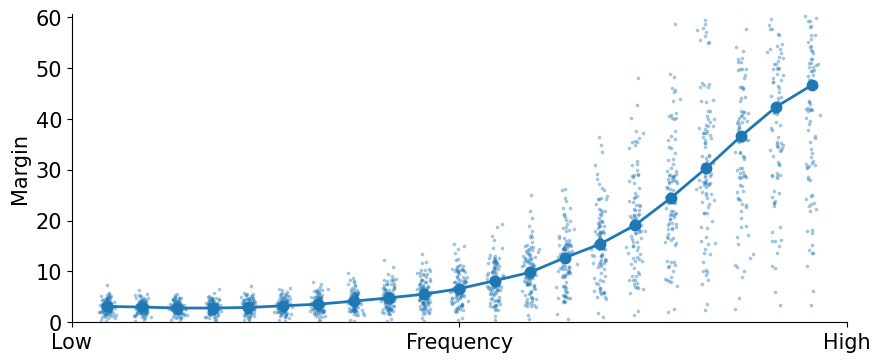

In [39]:
swarmplot(margins, color='tab:blue')

In [40]:
margins_ce = margins 

In [27]:
# margins_cl = margins 

In [41]:
swarmplot([margins_ce, margins_cl], labels=['ce', 'cl'], colors=['red', 'blue'])

TypeError: swarmplot() got an unexpected keyword argument 'labels'

## <a name=flipped>Flipped MNIST</a>

We now repeat the same procedure for the frequency flipped version of MNIST. We start first by flipping the data.

In [ ]:
from utils_dct import dct_flip

flip_train_data = dct_flip(trainset.data.type(torch.float32).view([-1, 1, 28, 28]) / 255.)
flip_test_data = dct_flip(testset.data.type(torch.float32).view([-1, 1, 28, 28]) / 255.)

flip_trainset = torch.utils.data.TensorDataset(flip_train_data, trainset.targets)
flip_testset = torch.utils.data.TensorDataset(flip_test_data, testset.targets)

flip_trainloader = torch.utils.data.DataLoader(flip_trainset, batch_size=BATCH_SIZE, shuffle=True,
                                               num_workers=2, pin_memory=pin_memory)
flip_testloader = torch.utils.data.DataLoader(flip_testset, batch_size=BATCH_SIZE, shuffle=False,
                                              num_workers=2, pin_memory=pin_memory)

Because we want to simply rotate (flip) the data we feed the network, we need to modify the normalization layer to account for the new representation

In [ ]:
from model_classes import TransformFlippedLayer
flip_trans = TransformFlippedLayer(mean, std, [1, 28, 28], DEVICE)

Let's train again a LeNet but on the data of the new (flipped) representation

In [ ]:
flip_model = LeNet()
flip_model = flip_model.to(DEVICE)

SAVE_TRAIN_DIR = os.path.join(TREE_ROOT, 'Models/Generated/%s_flipped/%s/' % ('MNIST', model.__class__.__name__))
os.makedirs(SAVE_TRAIN_DIR, exist_ok=True)

opt = torch.optim.SGD(flip_model.parameters(), lr=MAX_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
loss_fun = nn.CrossEntropyLoss()
lr_schedule = lambda t: np.interp([t], [0, EPOCHS * 2 // 5, EPOCHS], [0, MAX_LR, 0])[0]

t0 = time.time()

print('\n---> Training a LeNet architecture on Flipped MNIST')
flip_model = train(flip_model, flip_trans, flip_trainloader, flip_testloader, EPOCHS, opt, loss_fun, lr_schedule, SAVE_TRAIN_DIR)
print('---> Training is done! Elapsed time: %.5f minutes\n' % ((time.time() - t0) / 60.))

And compute the margin distribution of this model for the same data as before, but with a flipped representation

In [ ]:
flip_eval_dataset = torch.utils.data.Subset(flip_testset, indices[:NUM_SAMPLES_EVAL])
flip_eval_loader = torch.utils.data.DataLoader(flip_eval_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2, pin_memory=pin_memory)

RESULTS_DIR = os.path.join(TREE_ROOT, 'Results/margin_%s_flipped/%s/' % ('MNIST', model.__class__.__name__))
os.makedirs(RESULTS_DIR, exist_ok=True)
flip_margins = compute_margin_distribution(flip_model, flip_trans, flip_eval_loader, subspace_list, RESULTS_DIR + 'margins.npy')

In [ ]:
swarmplot(flip_margins, color='tab:red')

## <a name=images>Frequency manipulated image examples</a>

We now show a few image examples from the modified versions of the standard datasets.

### <a name=flipped_im>Flipped images</a>

Reproduce the flipped ImageNet examples of the Supplementary material

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt

IMAGE_DIR = os.path.join(TREE_ROOT, 'Images/')
DATASET = 'ImageNet'

for file in os.listdir(IMAGE_DIR + DATASET):
    im = Image.open(os.path.join(IMAGE_DIR, DATASET, file))

    im_flipped = dct_flip(torch.from_numpy(np.asarray(im).transpose((2, 0, 1))).float())
    im_flipped = im_flipped - im_flipped.min()
    im_flipped = im_flipped / im_flipped.max()
    im_flipped = Image.fromarray((255 * im_flipped.permute(1, 2, 0).numpy()).astype(np.uint8))

    cat_im = Image.new(im.mode, (2 * im.size[0], im.size[1]))
    cat_im.paste(im, (0, 0))
    cat_im.paste(im_flipped, (im.size[0], 0))

    display(cat_im)

Reproduce the flipped CIFAR-10 examples of the Supplementary material

In [ ]:
DATASET = 'CIFAR10'

for file in os.listdir(IMAGE_DIR + DATASET):
    im = Image.open(os.path.join(IMAGE_DIR, DATASET, file))

    im_flipped = dct_flip(torch.from_numpy(np.asarray(im).transpose((2, 0, 1))).float())
    im_flipped = im_flipped - im_flipped.min()
    im_flipped = im_flipped / im_flipped.max()
    im_flipped = Image.fromarray((255 * im_flipped.permute(1, 2, 0).numpy()).astype(np.uint8))

    cat_im = Image.new(im.mode, (2 * im.size[0], im.size[1]))
    cat_im.paste(im, (0, 0))
    cat_im.paste(im_flipped, (im.size[0], 0))

    display(cat_im)

Reproduce the flipped MNIST examples of the Supplementary material

In [ ]:
DATASET = 'MNIST'

for file in os.listdir(IMAGE_DIR + DATASET):
    im = Image.open(os.path.join(IMAGE_DIR, DATASET, file))

    im_flipped = dct_flip(torch.from_numpy(np.asarray(im)).float())
    im_flipped = im_flipped - im_flipped.min()
    im_flipped = im_flipped / im_flipped.max()
    im_flipped = Image.fromarray((255 * im_flipped.numpy()).astype(np.uint8))

    cat_im = Image.new(im.mode, (2 * im.size[0], im.size[1]))
    cat_im.paste(im, (0, 0))
    cat_im.paste(im_flipped, (im.size[0], 0))

    display(cat_im)

### <a name=filtered_im>Filtered images</a>

In [ ]:
from utils_dct import dct_low_pass
from utils_dct import dct_high_pass
from utils_dct import dct_cutoff_low


Reproduce the low-pass and high-pass CIFAR-10 examples of the Supplementary material

In [ ]:
DATASET = 'CIFAR10'
BANDWIDTH = 16

for file in os.listdir(IMAGE_DIR + DATASET):
    im = Image.open(os.path.join(IMAGE_DIR, DATASET, file))

    im_lp = dct_low_pass(torch.from_numpy(np.asarray(im).transpose((2, 0, 1))).float(), bandwidth=BANDWIDTH)
    im_lp = im_lp - im_lp.min()
    im_lp = im_lp / im_lp.max()
    im_lp = Image.fromarray((255 * im_lp.permute(1, 2, 0).numpy()).astype(np.uint8))
    
    im_hp = dct_high_pass(torch.from_numpy(np.asarray(im).transpose((2, 0, 1))).float(), bandwidth=BANDWIDTH)
    im_hp = im_hp - im_hp.min()
    im_hp = im_hp / im_hp.max()
    im_hp = Image.fromarray((255 * im_hp.permute(1, 2, 0).numpy()).astype(np.uint8))

    cat_im = Image.new(im.mode, (3 * im.size[0], im.size[1]))
    cat_im.paste(im, (0, 0))
    cat_im.paste(im_lp, (im.size[0], 0))
    cat_im.paste(im_hp, (2 * im.size[0], 0))

    display(cat_im)

Reproduce the high-pass MNIST examples of the Supplementary material

In [ ]:
DATASET = 'MNIST'
BANDWIDTH = 14

for file in os.listdir(IMAGE_DIR + DATASET):
    im = Image.open(os.path.join(IMAGE_DIR, DATASET, file))
    
    im_hp = dct_cutoff_low(torch.from_numpy(np.asarray(im)).float(), bandwidth=BANDWIDTH)
    im_hp = im_hp - im_hp.min()
    im_hp = im_hp / im_hp.max()
    im_hp = Image.fromarray((255 * im_hp.numpy()).astype(np.uint8))

    cat_im = Image.new(im.mode, (2 * im.size[0], im.size[1]))
    cat_im.paste(im, (0, 0))
    cat_im.paste(im_hp, (im.size[0], 0))

    display(cat_im)